<a href="https://colab.research.google.com/github/rabadgp/uimp-DL/blob/master/Entrega_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final - Fase II: Implementación de la solución propuesta

## 1. Introducción

Descripción de los algoritmos pre-entrenados propuestos y características por defecto.


## 2. Importar librerías

In [0]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from google.colab import drive

from keras import applications
from keras import metrics
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

from sklearn.model_selection import train_test_split

## 3. Preparación de datos de entrenamiento

### 3.1 Carga de datos

In [0]:

# Montamos el Google Drive en el directorio del proyecto el fichero DL_UNIMIB2016.zip y descomprimimos los ficheros:
#   /UNIMIB2016/images/*.jpg
#   /UNIMIB2016/percentages.csv
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/DL_master/DL_UNIMIB2016.zip' >> /dev/null

# Especificamos las rutas a los directorios que contienen las imágenes y el fichero de porcentajes
base_path = 'UNIMIB2016/'
img_path = base_path + 'images/'
pct_path = base_path + 'percentage.csv'

# Especificamos la estructura del fichero percentages.csv y el tamaño de la imagen
x_col = 'image_name'
y_col = 'food_pixels'
resize_factor=2
img_channels=3
img_size = [640,480]
img_shape = [dim//resize_factor for dim in img_size] + [img_channels]

# Lectura del fichero de CSV con los porcentajes
df = pd.read_csv(pct_path, dtype={y_col:'Float64'})



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 3.2 Obtención de los subconjuntos de entrenamiento, validación y prueba


In [0]:
# Creamos las particiones de entrenamiento y test y se actualizan los índice de cada partición
# train_data = 70%
# validation_data = 50% test_data
# test_data = 30%
seed = 986
train_data, test_data = train_test_split(df, test_size=0.3, random_state=seed)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Peparamos el conjunto de datos de entrenamiento y validación utilizando técnicas de data augmentation
# Las técnicas utilizadas no deberán modificar el porcentaje de pixels de la imágen original por lo que transformaciones de giro, desplazamiento y zoom están descartadas
# Se han considerando el volteo horizontal y vertical de imágenes, el cambio del rango del canal según un valor factor aleatorio en el rango [1,0.2] y la normalización de características

img_generator = ImageDataGenerator(
    rescale=1./255,
    channel_shift_range=0.8,
    brightness_range=[0.5,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.5) # Se define un subconjunto de validación de 1/2 sobre el subconjuto de test, para evitar overffiting durante el entrenamiento

# Generamos los batches para las particiones de train, validation y test
batch_size = 32
train_data_gen = img_generator.flow_from_dataframe(dataframe=train_data, directory=img_path, x_col=x_col, y_col=y_col, class_mode='raw',
                                               target_size=img_shape[:-1], batch_size=batch_size)
val_data_gen = img_generator.flow_from_dataframe(dataframe=test_data, directory=img_path, x_col=x_col, y_col=y_col, class_mode='raw',
                                               target_size=img_shape[:-1], batch_size=batch_size, subset='validation')
test_data_gen = img_generator.flow_from_dataframe(dataframe=test_data, directory=img_path, x_col=x_col, y_col=y_col, class_mode='raw',
                                               target_size=img_shape[:-1], batch_size=batch_size)


Found 718 validated image filenames.
Found 154 validated image filenames.
Found 309 validated image filenames.


## 4 Construcción de los modelos

### 4.1. Obtención de los modelos pre-entrenados

In [0]:
def retrive_model(model_name, trainable, dropout, weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg'):
  if model_name is 'DenseNet121':
    model = applications.DenseNet121(weights=weights, include_top=include_top, input_shape=input_shape, pooling=pooling)
  elif model_name is 'VGG16':
    model = applications.VGG16(weights=weights, include_top=include_top, input_shape=input_shape, pooling=pooling)
  elif model_name is 'Xception':
    model = applications.Xception(weights=weights, include_top=include_top, input_shape=input_shape, pooling=pooling)
  else: 
    raise ValueError('Model name not found')

  if not trainable:
    for layer in model.layers:
      model.trainable = trainable

  model = create_top_layer(model, n_cells=[1024,1], activations=['relu','relu'])
  model.summary()
  model.compile(loss='mean_squared_error',     # función de pérdida para problemas de regresión
                optimizer=optimizers.adam(lr=1e-5, decay=1e-2))  # optimizador Adam, learning rate (lr)
  return model
  
def create_top_layer(model, n_cells, activations):
  x = model.output
  for idx_layer in range(len(n_cells)-1):
    x = Dense(n_cells[idx_layer], activation=activations[idx_layer])(x)
    if dropout:
      x = Dropout(rate=0.2)(x)
  predictions = Dense(n_cells[-1], activation=activations[-1])(x)
  return Model(inputs=[model.input], outputs=[predictions], name=model.name)


### 4.2 Entrenamiento y evaluación de los modelos

NasNET issue:

*   Elemento de lista
*   Elemento de lista






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 320, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 60, 128)       0     

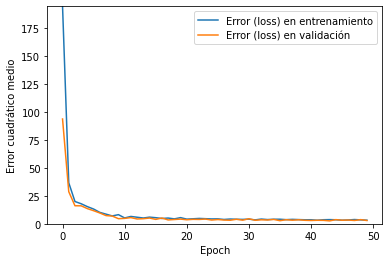

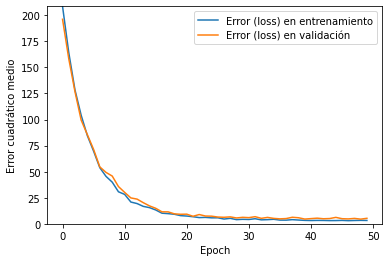

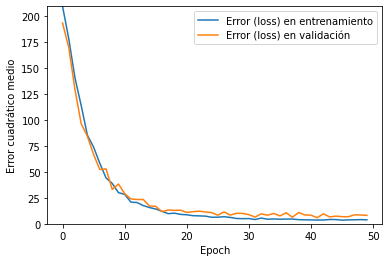

In [0]:
# Definimos el número de epochs y los modelos a entrenar para el entrenamiento de los modelos
epochs=50
models=['VGG16','DenseNet121', 'Xception']
histories=[]
evals=[]

# Entrenamos y evaluamos los modelos considerados
for model_name in models:
  # Construimos el modelo
  model=retrive_model(model_name=model_name, dropout=True, trainable=True)

  # Entrenamos el modelo
  history = model.fit_generator(train_data_gen, 
                      epochs=epochs, 
                      verbose=2, 
                      steps_per_epoch=train_data_gen.samples//train_data_gen.batch_size,
                      validation_data=val_data_gen,
                      validation_steps=val_data_gen.samples//val_data_gen.batch_size)
  histories.append(history)

  # Evaluamos el modelo y mostramos el error cuadrático medio como medida del error
  test_sme = model.evaluate_generator(test_data_gen, 
                                      steps=test_data_gen.samples/test_data_gen.batch_size, 
                                      verbose=1)
  evals.append(test_sme)
 

# Generamos los gráficos loss-epoch
# Mostramos información sobre el error min y máx durante el entrenamiento y el sme de la evaluación
for i in range(models):
  plot_history(histories[i])
  print("Máximo error:",max(np.array(history.history['loss'])))
  print("Mínimo error:",min(np.array(history.history['loss'])))
  print("Model: {}\tSME: {}".format(model.name, evals[i]))


# Función para imprimir las curvas loss-epoch de entrenamiento y validación
def plot_history(history):
  plt.figure()
  plt.title('Training model {}'.format(history.params['model']))
  plt.xlabel('Epoch')
  plt.ylabel('Error cuadrático medio')
  plt.plot(history.epoch, np.array(history.history['loss']),
           label='Error (loss) en entrenamiento')
  plt.plot(history.epoch, np.array(history.history['val_loss']),
           label='Error (loss) en validación')
  plt.legend()
  plt.ylim([0, max(1,max(np.array(history.history['loss'])))])


